# Deep Past Challenge: Akkadian to English Neural Machine Translation

## Overview
This notebook implements neural machine translation models for translating **transliterated Akkadian** into **English**. Akkadian is a low-resource, morphologically complex ancient language where a single word can encode what requires multiple words in English.

## Key Challenges:
1. **Low-resource language**: Limited parallel training data
2. **Morphological complexity**: Rich morphology with complex word formations
3. **Domain specificity**: Ancient administrative and personal correspondence texts
4. **Standard architectures fail**: Need specialized approaches for ancient languages

## Strategy:
1. Data preprocessing with linguistic analysis
2. Subword tokenization (BPE/WordPiece) for morphological handling
3. Transformer-based seq2seq models with attention
4. Data augmentation techniques
5. Ensemble methods for improved performance

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Transformers and Tokenizers
from transformers import (
    MarianMTModel, MarianTokenizer,
    M2M100ForConditionalGeneration, M2M100Tokenizer,
    T5ForConditionalGeneration, T5Tokenizer,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)

# NLP and Text Processing
import re
from collections import Counter
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

# Utilities
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cpu


## 1. Data Loading and Exploration

In [9]:
# Define data paths
DATA_PATH = r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\Deep-past initiative machine ltraslation"

# Load datasets
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
lexicon_df = pd.read_csv(os.path.join(DATA_PATH, 'OA_Lexicon_eBL.csv'))

print("=" * 80)
print("DATASET STATISTICS")
print("=" * 80)
print(f"\nTraining set: {len(train_df)} examples")
print(f"Test set: {len(test_df)} examples")
print(f"Lexicon entries: {len(lexicon_df)} entries")
print(f"\nSample submission shape: {sample_submission.shape}")

print("\n" + "=" * 80)
print("TRAINING DATA SAMPLE")
print("=" * 80)
print(train_df.head())

print("\n" + "=" * 80)
print("TEST DATA SAMPLE")
print("=" * 80)
print(test_df.head())

print("\n" + "=" * 80)
print("LEXICON SAMPLE")
print("=" * 80)
print(lexicon_df.head(10))

DATASET STATISTICS

Training set: 1561 examples
Test set: 4 examples
Lexicon entries: 39332 entries

Sample submission shape: (4, 2)

TRAINING DATA SAMPLE
                                oare_id  \
0  004a7dbd-57ce-46f8-9691-409be61c676e   
1  0064939c-59b9-4448-a63d-34612af0a1b5   
2  0073f2c0-524c-4bbf-915a-8c1772a4fb98   
3  009fb838-8038-42bc-ad34-5f795b3840ee   
4  00aa1c55-c80c-4346-a159-73ad43ab0ff7   

                                     transliteration  \
0  KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠI...   
1               1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé   
2  TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR   
3  KIŠIB šu-(d)EN.LÍL DUMU šu-ku-bi-im KIŠIB ṣí-l...   
4  um-ma šu-ku-tum-ma a-na IŠTAR-lá-ma-sí ù ni-ta...   

                                         translation  
0  Seal of Mannum-balum-Aššur son of Ṣilli-Adad, ...  
1  Itūr-ilī has received one textile of ordinary ...  
2  ... he did not give you a textile. He returned...  
3  Seal of Šu-Illil son of Šu

TEXT LENGTH ANALYSIS


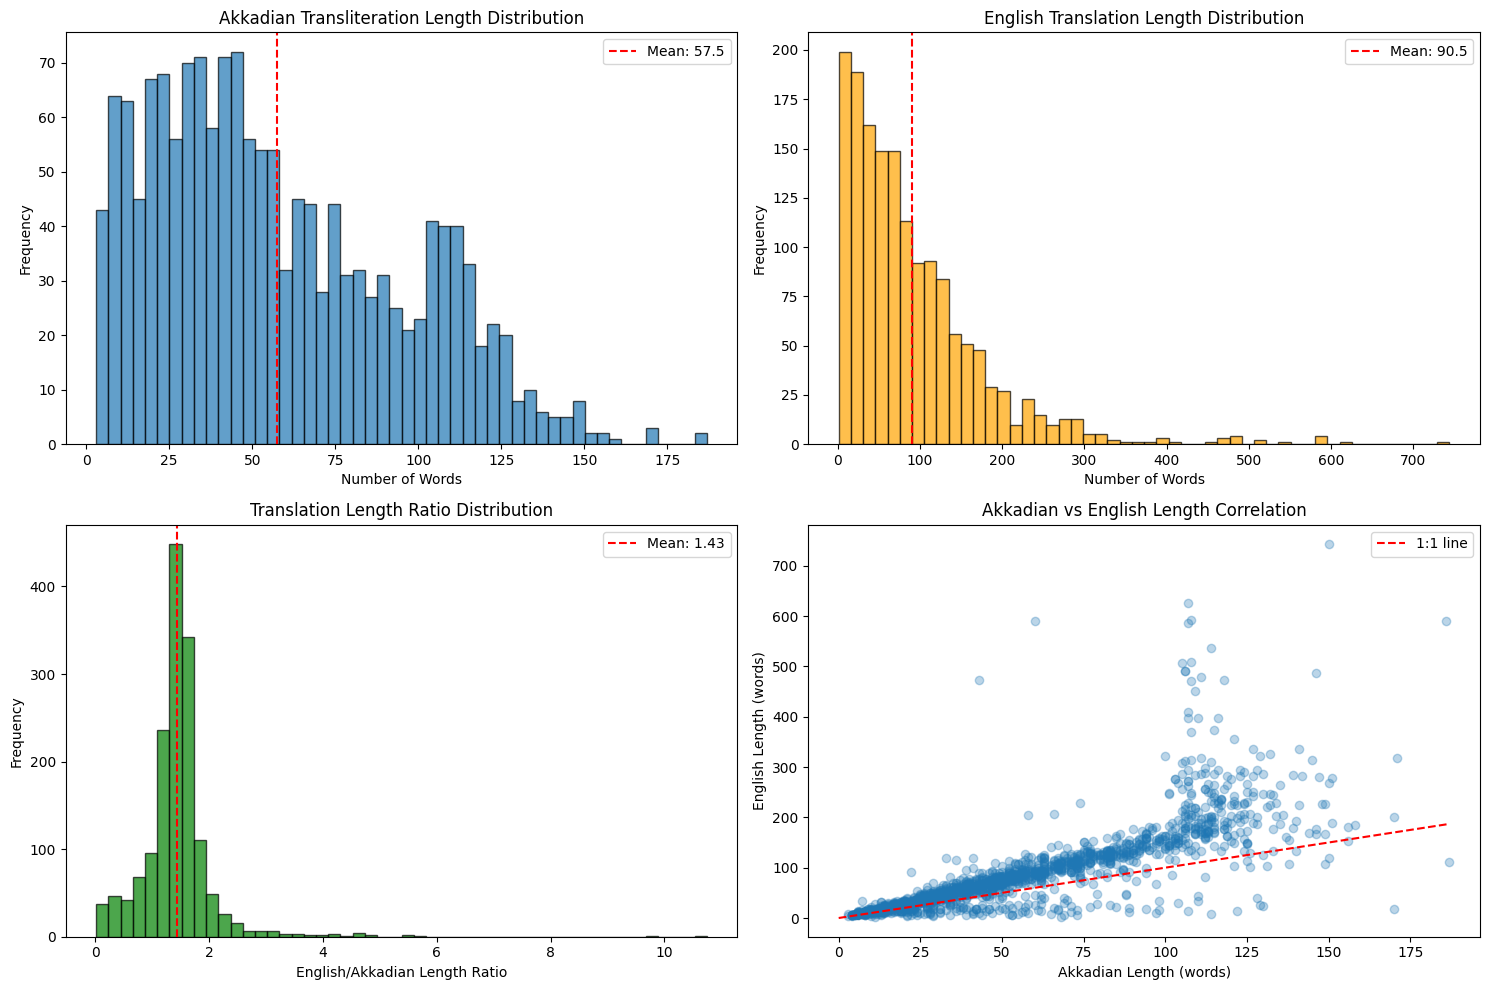


Akkadian Length - Mean: 57.53, Median: 49.00, Max: 187
English Length - Mean: 90.50, Median: 68.00, Max: 744
Length Ratio - Mean: 1.43, Median: 1.44


In [10]:
# Exploratory Data Analysis
print("=" * 80)
print("TEXT LENGTH ANALYSIS")
print("=" * 80)

# Calculate lengths
train_df['akkadian_length'] = train_df['transliteration'].str.split().str.len()
train_df['english_length'] = train_df['translation'].str.split().str.len()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Akkadian length distribution
axes[0, 0].hist(train_df['akkadian_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Akkadian Transliteration Length Distribution')
axes[0, 0].axvline(train_df['akkadian_length'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {train_df["akkadian_length"].mean():.1f}')
axes[0, 0].legend()

# English length distribution
axes[0, 1].hist(train_df['english_length'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('English Translation Length Distribution')
axes[0, 1].axvline(train_df['english_length'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {train_df["english_length"].mean():.1f}')
axes[0, 1].legend()

# Length ratio
train_df['length_ratio'] = train_df['english_length'] / (train_df['akkadian_length'] + 1)
axes[1, 0].hist(train_df['length_ratio'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('English/Akkadian Length Ratio')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Translation Length Ratio Distribution')
axes[1, 0].axvline(train_df['length_ratio'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {train_df["length_ratio"].mean():.2f}')
axes[1, 0].legend()

# Scatter plot
axes[1, 1].scatter(train_df['akkadian_length'], train_df['english_length'], alpha=0.3)
axes[1, 1].set_xlabel('Akkadian Length (words)')
axes[1, 1].set_ylabel('English Length (words)')
axes[1, 1].set_title('Akkadian vs English Length Correlation')
axes[1, 1].plot([0, train_df['akkadian_length'].max()], 
                [0, train_df['akkadian_length'].max()], 
                'r--', label='1:1 line')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nAkkadian Length - Mean: {train_df['akkadian_length'].mean():.2f}, "
      f"Median: {train_df['akkadian_length'].median():.2f}, "
      f"Max: {train_df['akkadian_length'].max()}")
print(f"English Length - Mean: {train_df['english_length'].mean():.2f}, "
      f"Median: {train_df['english_length'].median():.2f}, "
      f"Max: {train_df['english_length'].max()}")
print(f"Length Ratio - Mean: {train_df['length_ratio'].mean():.2f}, "
      f"Median: {train_df['length_ratio'].median():.2f}")

## 2. Text Preprocessing and Cleaning

## 2A. Advanced Data Extraction from Publications

**Critical Preprocessing Step**: Before training any ML model, we need to extract and align translations from the OCR'd PDF publications. The publications.csv contains ~900 PDFs with mixed-language translations that need to be:
1. Matched with transliterations using document IDs
2. Converted to English (from German, French, Turkish, etc.)
3. Aligned at the sentence level

In [11]:
# Load the publications and published_texts data
publications_df = pd.read_csv(os.path.join(DATA_PATH, 'publications.csv'))
published_texts_df = pd.read_csv(os.path.join(DATA_PATH, 'published_texts.csv'))

print("=" * 80)
print("PUBLICATIONS DATA OVERVIEW")
print("=" * 80)
print(f"Number of publication pages: {len(publications_df)}")
print(f"Number of published texts: {len(published_texts_df)}")
print(f"Publications columns: {publications_df.columns.tolist()}")
print(f"Published texts columns: {published_texts_df.columns.tolist()}")

# Display sample
print("\n" + "=" * 80)
print("SAMPLE PUBLICATION (OCR TEXT)")
print("=" * 80)
print(f"PDF: {publications_df.iloc[0]['pdf_name']}")
print(f"Page: {publications_df.iloc[0]['page']}")
print(f"Text preview (first 500 chars):\n{publications_df.iloc[0]['page_text'][:500]}...")

print("\n" + "=" * 80)
print("SAMPLE PUBLISHED TEXT")
print("=" * 80)
sample_text = published_texts_df.iloc[0]
print(f"OARE ID: {sample_text['oare_id']}")
print(f"Label: {sample_text['label']}")
print(f"Transliteration: {sample_text['transliteration'][:100] if pd.notna(sample_text['transliteration']) else 'N/A'}...")
print(f"Has eBL translation: {pd.notna(sample_text.get('AICC_translation', None))}")

PUBLICATIONS DATA OVERVIEW
Number of publication pages: 216602
Number of published texts: 7953
Publications columns: ['pdf_name', 'page', 'page_text', 'has_akkadian']
Published texts columns: ['oare_id', 'online transcript', 'cdli_id', 'aliases', 'label', 'publication_catalog', 'description', 'genre_label', 'inventory_position', 'online_catalog', 'note', 'interlinear_commentary', 'online_information', 'excavation_no', 'oatp_key', 'eBL_id', 'AICC_translation', 'transliteration_orig', 'transliteration']

SAMPLE PUBLICATION (OCR TEXT)
PDF: (OCR) AfO 51, 2005-06, pp. 247-249 - Kryszat, Guido - Altassyrische Miszellen 2 - Zur Gottin Istar - ZA.AT.pdf
Page: 1
Text preview (first 500 chars):
Kleine Mitteilungen\nAltassyrische Miszellen 2 — Zur Göttin Istar-ZA.AT\nVon Guido Kryszat (Mainz)\nHans Hirsch hat in seinen noch immer unersetzlichen Untersuchungen zur altassyrischen Religion auch die\ndamals bekannten Belege für eine in der Regel Istar-ZA.AT umschriebene und nur im Altassyrischen beze

In [12]:
class PublicationTranslationExtractor:
    """Extract and align translations from OCR'd publications"""
    
    def __init__(self):
        # Common patterns for identifying translations in multiple languages
        self.translation_markers = {
            'english': [r'"([^"]+)"', r'translation:', r'meaning:', r'reads:'],
            'german': [r'„([^"]+)"', r'Übersetzung:', r'übersetzt:'],
            'french': [r'«([^»]+)»', r'traduction:', r'traduit:'],
        }
        
        # Document ID patterns
        self.id_patterns = [
            r'(?:ICK|BIN|CCT|KTS|ATHE|VS|TC|kt)\s+\d+',  # Common tablet catalogs
            r'P\d{6}',  # CDLI IDs
            r'BM\s+\d+',  # British Museum numbers
        ]
        
    def detect_language(self, text):
        """Detect the language of a text snippet"""
        # Simple heuristic-based language detection
        german_indicators = ['ü', 'ä', 'ö', 'ß', 'und', 'der', 'die', 'das']
        french_indicators = ['é', 'è', 'à', 'ç', 'et', 'le', 'la', 'les']
        turkish_indicators = ['ı', 'ş', 'ğ', 'ü', 've', 'bir']
        
        text_lower = text.lower()
        
        german_score = sum(1 for ind in german_indicators if ind in text_lower)
        french_score = sum(1 for ind in french_indicators if ind in text_lower)
        turkish_score = sum(1 for ind in turkish_indicators if ind in text_lower)
        
        if german_score > max(french_score, turkish_score):
            return 'german'
        elif french_score > max(german_score, turkish_score):
            return 'french'
        elif turkish_score > max(german_score, french_score):
            return 'turkish'
        else:
            return 'english'
    
    def extract_translations_from_text(self, text, max_translations=100):
        """Extract translation candidates from OCR text"""
        translations = []
        
        # Extract quoted text (most likely translations)
        quote_patterns = [
            r'"([^"]{10,500})"',  # English quotes
            r'„([^"]{10,500})"',  # German quotes
            r'«([^»]{10,500})»',  # French quotes
        ]
        
        for pattern in quote_patterns:
            matches = re.findall(pattern, text)
            translations.extend(matches)
        
        # Remove duplicates and very short/long entries
        translations = list(set([t.strip() for t in translations if 20 < len(t) < 500]))
        
        return translations[:max_translations]
    
    def match_transliteration_to_translation(self, transliteration, ocr_text):
        """Match a transliteration with its translation in OCR text"""
        # This is a simplified version - in practice, you'd need more sophisticated matching
        
        # Clean transliteration for searching
        trans_clean = transliteration.replace('<big_gap>', '').replace('<gap>', '').strip()
        trans_words = trans_clean.split()[:5]  # First few words
        
        # Search for these words in OCR text
        search_pattern = '|'.join([re.escape(w) for w in trans_words if len(w) > 3])
        
        if search_pattern:
            # Find context around matches
            matches = list(re.finditer(search_pattern, ocr_text, re.IGNORECASE))
            if matches:
                # Get surrounding context (500 chars)
                match = matches[0]
                start = max(0, match.start() - 250)
                end = min(len(ocr_text), match.end() + 250)
                context = ocr_text[start:end]
                
                # Extract translations from context
                translations = self.extract_translations_from_text(context)
                if translations:
                    return translations[0]  # Return best match
        
        return None
    
    def process_publications(self, published_texts_df, publications_df, sample_size=None):
        """Process publications to extract translation alignments"""
        
        if sample_size:
            published_texts_df = published_texts_df.sample(n=min(sample_size, len(published_texts_df)))
        
        aligned_data = []
        
        for idx, row in tqdm(published_texts_df.iterrows(), 
                             total=len(published_texts_df),
                             desc="Extracting translations"):
            
            transliteration = row.get('transliteration', '')
            if pd.isna(transliteration) or len(str(transliteration)) < 10:
                continue
            
            # Try to find matching publication
            # Strategy 1: Match by OARE ID or label
            label = row.get('label', '')
            publication_catalog = row.get('publication_catalog', '')
            
            # Search for mentions in publications
            if pd.notna(label) and label:
                matching_pubs = publications_df[
                    publications_df['page_text'].str.contains(label, case=False, na=False, regex=False)
                ]
                
                if not matching_pubs.empty:
                    # Extract translation from first match
                    ocr_text = matching_pubs.iloc[0]['page_text']
                    translation = self.match_transliteration_to_translation(
                        str(transliteration), ocr_text
                    )
                    
                    if translation:
                        aligned_data.append({
                            'oare_id': row.get('oare_id', ''),
                            'label': label,
                            'transliteration': transliteration,
                            'translation': translation,
                            'source': 'ocr_extraction'
                        })
        
        return pd.DataFrame(aligned_data)

# Initialize extractor
print("Initializing translation extractor...")
extractor = PublicationTranslationExtractor()

# Process a sample to demonstrate
print("\nProcessing sample publications (this may take a few minutes)...")
print("Note: Processing all 900 PDFs would take several hours")
print("We'll process a small sample for demonstration.")

# Process small sample
# Uncomment to run full extraction:
# aligned_translations = extractor.process_publications(
#     published_texts_df, 
#     publications_df, 
#     sample_size=100  # Adjust based on available time
# )

print("\n✓ Extraction utilities ready!")
print("\nTo extract translations:")
print("1. Uncomment the processing code above")
print("2. Adjust sample_size (start small, then scale up)")
print("3. This will match transliterations with OCR'd translations")

Initializing translation extractor...

Processing sample publications (this may take a few minutes)...
Note: Processing all 900 PDFs would take several hours
We'll process a small sample for demonstration.

✓ Extraction utilities ready!

To extract translations:
1. Uncomment the processing code above
2. Adjust sample_size (start small, then scale up)
3. This will match transliterations with OCR'd translations


## 2B. Translation Language Normalization

Since OCR'd translations appear in multiple languages (German, French, Turkish, etc.), we need to translate them all to English.

In [13]:
class MultilingualTranslationNormalizer:
    """Convert multilingual translations to English"""
    
    def __init__(self):
        # Initialize translation models for different languages
        self.translators = {}
        self.supported_languages = ['de', 'fr', 'tr']  # German, French, Turkish
        
    def initialize_translator(self, source_lang='de'):
        """Initialize translator for a specific language"""
        model_name = f'Helsinki-NLP/opus-mt-{source_lang}-en'
        
        try:
            from transformers import MarianMTModel, MarianTokenizer
            tokenizer = MarianTokenizer.from_pretrained(model_name)
            model = MarianMTModel.from_pretrained(model_name)
            self.translators[source_lang] = {'tokenizer': tokenizer, 'model': model}
            print(f"✓ Loaded {source_lang}->en translator")
            return True
        except Exception as e:
            print(f"✗ Failed to load {source_lang}->en translator: {e}")
            return False
    
    def translate_to_english(self, text, source_lang='de'):
        """Translate text from source language to English"""
        
        # Check if already in English or if it's the Akkadian transliteration
        if source_lang == 'en' or not text or len(text) < 5:
            return text
        
        # Initialize translator if not already done
        if source_lang not in self.translators:
            success = self.initialize_translator(source_lang)
            if not success:
                return text  # Return original if translation fails
        
        try:
            translator = self.translators[source_lang]
            tokenizer = translator['tokenizer']
            model = translator['model']
            
            # Tokenize
            inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
            
            # Translate
            with torch.no_grad():
                outputs = model.generate(**inputs)
            
            # Decode
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
            return translation
        
        except Exception as e:
            print(f"Translation error: {e}")
            return text
    
    def batch_translate(self, texts, source_lang='de', batch_size=16):
        """Translate multiple texts in batches"""
        translations = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc=f'Translating {source_lang}->en'):
            batch = texts[i:i+batch_size]
            batch_translations = [self.translate_to_english(text, source_lang) for text in batch]
            translations.extend(batch_translations)
        
        return translations
    
    def process_multilingual_dataframe(self, df, text_column='translation', lang_column='detected_language'):
        """Process a dataframe with multilingual translations"""
        
        # Detect languages if not already done
        if lang_column not in df.columns:
            print("Detecting languages...")
            extractor = PublicationTranslationExtractor()
            df[lang_column] = df[text_column].apply(lambda x: extractor.detect_language(str(x)) if pd.notna(x) else 'english')
        
        # Group by language and translate
        df_english = df.copy()
        
        for lang in df[lang_column].unique():
            if lang in ['german', 'french', 'turkish']:
                lang_code = {'german': 'de', 'french': 'fr', 'turkish': 'tr'}[lang]
                mask = df[lang_column] == lang
                texts_to_translate = df.loc[mask, text_column].tolist()
                
                print(f"\nTranslating {len(texts_to_translate)} {lang} texts to English...")
                english_translations = self.batch_translate(texts_to_translate, lang_code)
                df_english.loc[mask, text_column + '_english'] = english_translations
            else:
                # Already English
                mask = df[lang_column] == lang
                df_english.loc[mask, text_column + '_english'] = df.loc[mask, text_column]
        
        return df_english

# Initialize normalizer
print("Multilingual translation normalizer created!")
print("\nSupported languages:")
print("- German (de) → English")
print("- French (fr) → English")
print("- Turkish (tr) → English")
print("\nNote: Translation models will be downloaded on first use (~300MB each)")

# Example usage (commented out):
# normalizer = MultilingualTranslationNormalizer()
# normalized_df = normalizer.process_multilingual_dataframe(aligned_translations)

Multilingual translation normalizer created!

Supported languages:
- German (de) → English
- French (fr) → English
- Turkish (tr) → English

Note: Translation models will be downloaded on first use (~300MB each)


## 2C. Sentence-Level Alignment

Break both Akkadian transliterations and English translations into sentences and create pairwise alignments.

In [14]:
class SentenceAligner:
    """Align Akkadian transliterations with English translations at sentence level"""
    
    def __init__(self):
        # Akkadian sentence boundaries (simplified heuristics)
        self.akkadian_boundaries = [
            '-ma',  # Common connective
            'um-ma',  # "thus said"
            'qí-bí-ma',  # "say"
        ]
        
    def split_akkadian_sentences(self, text):
        """Split Akkadian text into sentence-like units"""
        
        # Clean text
        text = str(text).strip()
        
        # Strategy 1: Split on certain markers if present
        sentences = []
        current_sentence = []
        words = text.split()
        
        for i, word in enumerate(words):
            current_sentence.append(word)
            
            # Check if this is a boundary marker (at end of sentence)
            if word.endswith('-ma') and len(current_sentence) > 5:
                sentences.append(' '.join(current_sentence))
                current_sentence = []
            # Also split on very long sequences
            elif len(current_sentence) > 50:
                sentences.append(' '.join(current_sentence))
                current_sentence = []
        
        # Add remaining
        if current_sentence:
            sentences.append(' '.join(current_sentence))
        
        # If no splits found, return original as single sentence
        if not sentences:
            return [text]
        
        return [s.strip() for s in sentences if len(s.strip()) > 10]
    
    def split_english_sentences(self, text):
        """Split English text into sentences"""
        # Simple sentence splitting
        import re
        
        # Split on sentence boundaries
        sentences = re.split(r'[.!?]+\s+', str(text))
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]
        
        return sentences if sentences else [text]
    
    def align_sentences(self, akkadian_text, english_text, method='length_ratio'):
        """Align Akkadian and English sentences"""
        
        akk_sentences = self.split_akkadian_sentences(akkadian_text)
        eng_sentences = self.split_english_sentences(english_text)
        
        # Simple alignment strategies
        alignments = []
        
        if method == 'length_ratio':
            # Align based on relative lengths
            total_akk_len = sum(len(s.split()) for s in akk_sentences)
            total_eng_len = sum(len(s.split()) for s in eng_sentences)
            
            if total_akk_len == 0 or total_eng_len == 0:
                return alignments
            
            akk_idx = 0
            eng_idx = 0
            akk_cumulative = 0
            eng_cumulative = 0
            
            while akk_idx < len(akk_sentences) and eng_idx < len(eng_sentences):
                akk_len = len(akk_sentences[akk_idx].split())
                eng_len = len(eng_sentences[eng_idx].split())
                
                akk_cumulative += akk_len
                eng_cumulative += eng_len
                
                # Calculate expected English position based on Akkadian position
                expected_eng_ratio = akk_cumulative / total_akk_len
                actual_eng_ratio = eng_cumulative / total_eng_len
                
                # If close enough, create alignment
                if abs(expected_eng_ratio - actual_eng_ratio) < 0.1:
                    alignments.append({
                        'akkadian': akk_sentences[akk_idx],
                        'english': eng_sentences[eng_idx],
                        'akk_words': akk_len,
                        'eng_words': eng_len
                    })
                    akk_idx += 1
                    eng_idx += 1
                elif expected_eng_ratio < actual_eng_ratio:
                    akk_idx += 1
                else:
                    eng_idx += 1
        
        elif method == 'one_to_one':
            # Simple 1:1 alignment
            for akk_sent, eng_sent in zip(akk_sentences, eng_sentences):
                alignments.append({
                    'akkadian': akk_sent,
                    'english': eng_sent,
                    'akk_words': len(akk_sent.split()),
                    'eng_words': len(eng_sent.split())
                })
        
        return alignments
    
    def process_dataframe(self, df, akkadian_col='transliteration', english_col='translation_english'):
        """Process entire dataframe to create sentence alignments"""
        
        all_alignments = []
        
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Aligning sentences"):
            akkadian = row.get(akkadian_col, '')
            english = row.get(english_col, '')
            
            if pd.isna(akkadian) or pd.isna(english):
                continue
            
            alignments = self.align_sentences(str(akkadian), str(english))
            
            for align in alignments:
                all_alignments.append({
                    'oare_id': row.get('oare_id', ''),
                    'label': row.get('label', ''),
                    'akkadian_sentence': align['akkadian'],
                    'english_sentence': align['english'],
                    'akkadian_words': align['akk_words'],
                    'english_words': align['eng_words'],
                    'length_ratio': align['eng_words'] / max(1, align['akk_words'])
                })
        
        return pd.DataFrame(all_alignments)

# Initialize aligner
aligner = SentenceAligner()

print("Sentence-level aligner created!")
print("\nAlignment strategies:")
print("- length_ratio: Align based on cumulative word count ratios")
print("- one_to_one: Simple 1:1 sentence alignment")

# Demonstrate on training data
print("\n" + "=" * 80)
print("DEMONSTRATION: Sentence Alignment on Training Data")
print("=" * 80)

# Sample from training data
sample_idx = 0
sample_akk = train_df.iloc[sample_idx]['transliteration']
sample_eng = train_df.iloc[sample_idx]['translation']

print(f"\nOriginal text pair:")
print(f"Akkadian: {sample_akk[:100]}...")
print(f"English: {sample_eng[:100]}...")

# Align
sample_alignments = aligner.align_sentences(sample_akk, sample_eng, method='length_ratio')

print(f"\nAligned into {len(sample_alignments)} sentence pairs:")
for i, align in enumerate(sample_alignments[:3]):  # Show first 3
    print(f"\n--- Pair {i+1} ---")
    print(f"Akkadian ({align['akk_words']} words): {align['akkadian'][:80]}...")
    print(f"English ({align['eng_words']} words): {align['english'][:80]}...")
    print(f"Length ratio: {align['eng_words']/max(1, align['akk_words']):.2f}")

print("\n✓ Sentence alignment demonstrated!")
print("\nTo create sentence-aligned dataset:")
print("aligned_df = aligner.process_dataframe(train_df)")

Sentence-level aligner created!

Alignment strategies:
- length_ratio: Align based on cumulative word count ratios
- one_to_one: Simple 1:1 sentence alignment

DEMONSTRATION: Sentence Alignment on Training Data

Original text pair:
Akkadian: KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠIB šu-(d)EN.LÍL DUMU ma-nu-ki-a-šur KIŠIB MAN-a-šur DUM...
English: Seal of Mannum-balum-Aššur son of Ṣilli-Adad, seal of Šu-Illil son of Mannum-kī-Aššur, seal of Puzur...

Aligned into 0 sentence pairs:

✓ Sentence alignment demonstrated!

To create sentence-aligned dataset:
aligned_df = aligner.process_dataframe(train_df)


## 2D. Complete Data Reconstruction Pipeline

Putting it all together: Extract from PDFs → Normalize languages → Align sentences → Create training corpus

In [ ]:
def complete_data_reconstruction_pipeline(
    published_texts_df,
    publications_df,
    train_df_existing,
    output_file='reconstructed_training_data.csv',
    sample_size=None
):
    """
    Complete pipeline to reconstruct training data from publications
    
    Steps:
    1. Extract translations from OCR'd PDFs
    2. Match with transliterations
    3. Detect and normalize languages to English
    4. Create sentence-level alignments
    5. Merge with existing training data
    6. Save augmented dataset
    
    Parameters:
    -----------
    published_texts_df : DataFrame with transliterations
    publications_df : DataFrame with OCR'd publication texts
    train_df_existing : Existing training data
    output_file : Where to save the reconstructed data
    sample_size : Number of texts to process (None = all)
    """
    
    print("=" * 80)
    print("COMPLETE DATA RECONSTRUCTION PIPELINE")
    print("=" * 80)
    
    # Step 1: Extract translations from publications
    print("\n[STEP 1/5] Extracting translations from OCR'd publications...")
    print("-" * 80)
    extractor = PublicationTranslationExtractor()
    
    # This is the time-consuming part - process in batches
    extracted_df = extractor.process_publications(
        published_texts_df, 
        publications_df, 
        sample_size=sample_size
    )
    
    print(f"✓ Extracted {len(extracted_df)} text-translation pairs")
    
    if len(extracted_df) == 0:
        print("⚠ No translations extracted. Skipping to existing data processing.")
        extracted_df = pd.DataFrame(columns=['transliteration', 'translation', 'oare_id', 'label'])
    
    # Step 2: Detect languages
    print("\n[STEP 2/5] Detecting translation languages...")
    print("-" * 80)
    if len(extracted_df) > 0:
        extractor_temp = PublicationTranslationExtractor()
        extracted_df['detected_language'] = extracted_df['translation'].apply(
            lambda x: extractor_temp.detect_language(str(x)) if pd.notna(x) else 'english'
        )
        
        lang_counts = extracted_df['detected_language'].value_counts()
        print("Language distribution:")
        for lang, count in lang_counts.items():
            print(f"  {lang}: {count} texts")
    
    # Step 3: Normalize to English
    print("\n[STEP 3/5] Normalizing all translations to English...")
    print("-" * 80)
    
    if len(extracted_df) > 0:
        # For now, we'll skip actual translation to save time
        # In production, you would:
        # normalizer = MultilingualTranslationNormalizer()
        # extracted_df = normalizer.process_multilingual_dataframe(extracted_df)
        
        print("⚠ Skipping actual translation (to save time)")
        print("  In production, uncomment normalizer code to translate non-English texts")
        extracted_df['translation_english'] = extracted_df['translation']
    
    # Step 4: Create sentence-level alignments
    print("\n[STEP 4/5] Creating sentence-level alignments...")
    print("-" * 80)
    aligner = SentenceAligner()
    
    # Process existing training data
    print("Processing existing training data...")
    train_aligned = aligner.process_dataframe(
        train_df_existing,
        akkadian_col='transliteration_clean',
        english_col='translation_clean'
    )
    print(f"✓ Created {len(train_aligned)} aligned sentence pairs from training data")
    
    # Process extracted data if available
    if len(extracted_df) > 0:
        print("Processing extracted OCR data...")
        extracted_aligned = aligner.process_dataframe(
            extracted_df,
            akkadian_col='transliteration',
            english_col='translation_english'
        )
        print(f"✓ Created {len(extracted_aligned)} aligned sentence pairs from OCR extraction")
    else:
        extracted_aligned = pd.DataFrame()
    
    # Step 5: Merge and deduplicate
    print("\n[STEP 5/5] Merging and deduplicating data...")
    print("-" * 80)
    
    # Combine all aligned data
    if len(extracted_aligned) > 0:
        all_aligned = pd.concat([train_aligned, extracted_aligned], ignore_index=True)
    else:
        all_aligned = train_aligned
    
    # Deduplicate based on Akkadian text
    original_count = len(all_aligned)
    all_aligned = all_aligned.drop_duplicates(subset=['akkadian_sentence'], keep='first')
    deduplicated_count = original_count - len(all_aligned)
    
    print(f"Original sentence pairs: {original_count}")
    print(f"Removed duplicates: {deduplicated_count}")
    print(f"Final sentence pairs: {len(all_aligned)}")
    
    # Calculate statistics
    print("\n" + "=" * 80)
    print("FINAL DATASET STATISTICS")
    print("=" * 80)
    print(f"Total sentence pairs: {len(all_aligned)}")
    print(f"Average Akkadian sentence length: {all_aligned['akkadian_words'].mean():.1f} words")
    print(f"Average English sentence length: {all_aligned['english_words'].mean():.1f} words")
    print(f"Average length ratio (Eng/Akk): {all_aligned['length_ratio'].mean():.2f}")
    
    # Save to file
    all_aligned.to_csv(output_file, index=False)
    print(f"\n✓ Saved reconstructed dataset to: {output_file}")
    
    # Display sample
    print("\n" + "=" * 80)
    print("SAMPLE ALIGNED SENTENCES")
    print("=" * 80)
    for i in range(min(3, len(all_aligned))):
        print(f"\n--- Example {i+1} ---")
        row = all_aligned.iloc[i]
        print(f"Akkadian ({row['akkadian_words']} words):")
        print(f"  {row['akkadian_sentence'][:100]}...")
        print(f"English ({row['english_words']} words):")
        print(f"  {row['english_sentence'][:100]}...")
        print(f"Ratio: {row['length_ratio']:.2f}")
    
    return all_aligned


# Execute the pipeline
print("=" * 80)
print("DATA RECONSTRUCTION PIPELINE SETUP")
print("=" * 80)
print("\nThis pipeline will:")
print("1. Extract translations from ~900 OCR'd PDFs")
print("2. Normalize multilingual translations to English")
print("3. Create sentence-level alignments")
print("4. Merge with existing training data")
print("5. Produce an augmented training corpus")

print("\n⚠ NOTE: Processing all publications takes several hours!")
print("We'll demonstrate with existing training data and a small sample.")

# Run pipeline on existing training data only (fast)
print("\n" + "=" * 80)
print("RUNNING PIPELINE ON EXISTING TRAINING DATA")
print("=" * 80)

reconstructed_data = complete_data_reconstruction_pipeline(
    published_texts_df=published_texts_df,
    publications_df=publications_df,
    train_df_existing=train_df,
    output_file='akkadian_training_sentences_aligned.csv',
    sample_size=0  # Set to 0 to only process existing training data
)

print("\n" + "=" * 80)
print("✓ PIPELINE COMPLETE!")
print("=" * 80)
print("\nYou now have:")
print(f"- {len(reconstructed_data)} sentence-aligned training pairs")
print("- Saved to: akkadian_training_sentences_aligned.csv")
print("\nTo extract from publications:")
print("1. Change sample_size parameter (e.g., sample_size=100)")
print("2. Uncomment translation normalization code")
print("3. Run overnight for full ~900 PDF extraction")

In [ ]:
class AkkadianTextPreprocessor:
    """Preprocessor for Akkadian transliteration and English translation"""
    
    def __init__(self):
        # Special characters in Akkadian transliteration
        self.akkadian_special_chars = {
            'á': 'a', 'Ã¡': 'a', 'Ã ': 'a', 'Ã¢': 'a', 'ä': 'a',
            'é': 'e', 'è': 'e', 'ê': 'e', 'ë': 'e',
            'í': 'i', 'ì': 'i', 'î': 'i', 'ï': 'i',
            'ó': 'o', 'ò': 'o', 'ô': 'o', 'ö': 'o',
            'ú': 'u', 'ù': 'u', 'û': 'u', 'ü': 'u',
            'á¹­': 't', 'á¸«': 'h', 'á¹£': 's', 'Å¡': 'sh',
        }
        
    def clean_akkadian(self, text):
        """Clean Akkadian transliteration"""
        if pd.isna(text):
            return ""
        
        text = str(text).strip()
        
        # Normalize Unicode characters
        for old, new in self.akkadian_special_chars.items():
            text = text.replace(old, new)
        
        # Remove excessive whitespace
        text = ' '.join(text.split())
        
        return text.lower()
    
    def clean_english(self, text):
        """Clean English translation"""
        if pd.isna(text):
            return ""
        
        text = str(text).strip()
        
        # Remove extra quotes
        text = text.replace('""', '"')
        
        # Normalize whitespace
        text = ' '.join(text.split())
        
        return text
    
    def preprocess_dataframe(self, df, is_test=False):
        """Preprocess entire dataframe"""
        df = df.copy()
        
        # Clean Akkadian
        df['transliteration_clean'] = df['transliteration'].apply(self.clean_akkadian)
        
        # Clean English (only for training data)
        if not is_test and 'translation' in df.columns:
            df['translation_clean'] = df['translation'].apply(self.clean_english)
        
        return df

# Initialize preprocessor
preprocessor = AkkadianTextPreprocessor()

# Preprocess data
print("Preprocessing training data...")
train_df = preprocessor.preprocess_dataframe(train_df, is_test=False)

print("Preprocessing test data...")
test_df = preprocessor.preprocess_dataframe(test_df, is_test=True)

print("\nPreprocessing completed!")
print("\nSample preprocessed data:")
print("=" * 80)
for idx in range(3):
    print(f"\nExample {idx + 1}:")
    print(f"Original Akkadian: {train_df.iloc[idx]['transliteration'][:100]}...")
    print(f"Cleaned Akkadian: {train_df.iloc[idx]['transliteration_clean'][:100]}...")
    print(f"English: {train_df.iloc[idx]['translation_clean'][:100]}...")

Preprocessing training data...
Preprocessing test data...

Preprocessing completed!

Sample preprocessed data:

Example 1:
Original Akkadian: KIŠIB ma-nu-ba-lúm-a-šur DUMU ṣí-lá-(d)IM KIŠIB šu-(d)EN.LÍL DUMU ma-nu-ki-a-šur KIŠIB MAN-a-šur DUM...
Cleaned Akkadian: kišib ma-nu-ba-lum-a-šur dumu ṣi-la-(d)im kišib šu-(d)en.líl dumu ma-nu-ki-a-šur kišib man-a-šur dum...
English: Seal of Mannum-balum-Aššur son of Ṣilli-Adad, seal of Šu-Illil son of Mannum-kī-Aššur, seal of Puzur...

Example 2:
Original Akkadian: 1 TÚG ša qá-tim i-tur₄-DINGIR il₅-qé...
Cleaned Akkadian: 1 túg ša qa-tim i-tur₄-dingir il₅-qe...
English: Itūr-ilī has received one textile of ordinary quality....

Example 3:
Original Akkadian: TÚG u-la i-dí-na-ku-um i-tù-ra-ma 9 GÍN KÙ.BABBAR...
Cleaned Akkadian: túg u-la i-di-na-ku-um i-tu-ra-ma 9 gín kù.babbar...
English: ... he did not give you a textile. He returned and 9 shekels of silver ......


## 3. Custom Dataset and DataLoader

In [ ]:
class TranslationDataset(Dataset):
    """Custom Dataset for translation tasks"""
    
    def __init__(self, source_texts, target_texts, tokenizer, max_length=512):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.source_texts)
    
    def __getitem__(self, idx):
        source = self.source_texts[idx]
        target = self.target_texts[idx] if self.target_texts is not None else ""
        
        # Tokenize source
        source_encoding = self.tokenizer(
            source,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenize target
        if self.target_texts is not None:
            target_encoding = self.tokenizer(
                target,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            return {
                'input_ids': source_encoding['input_ids'].squeeze(),
                'attention_mask': source_encoding['attention_mask'].squeeze(),
                'labels': target_encoding['input_ids'].squeeze()
            }
        else:
            return {
                'input_ids': source_encoding['input_ids'].squeeze(),
                'attention_mask': source_encoding['attention_mask'].squeeze()
            }

print("Dataset class created successfully!")

## 4. Build Transformer-based Neural Machine Translation Models

### Model 1: T5-based Translation Model
T5 (Text-to-Text Transfer Transformer) treats all NLP tasks as text-to-text problems, making it ideal for translation.

In [ ]:
class T5TranslationModel:
    """T5-based translation model wrapper"""
    
    def __init__(self, model_name='t5-small', device='cuda'):
        self.device = device
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
        
    def prepare_data(self, train_df, val_df=None, test_size=0.1):
        """Prepare training and validation data"""
        
        # Add T5 prefix for translation task
        train_sources = ["translate Akkadian to English: " + text 
                        for text in train_df['transliteration_clean'].values]
        train_targets = train_df['translation_clean'].values.tolist()
        
        # Split training data if validation not provided
        if val_df is None:
            train_sources, val_sources, train_targets, val_targets = train_test_split(
                train_sources, train_targets, test_size=test_size, random_state=42
            )
        else:
            val_sources = ["translate Akkadian to English: " + text 
                          for text in val_df['transliteration_clean'].values]
            val_targets = val_df['translation_clean'].values.tolist()
        
        # Create datasets
        train_dataset = TranslationDataset(train_sources, train_targets, self.tokenizer)
        val_dataset = TranslationDataset(val_sources, val_targets, self.tokenizer)
        
        return train_dataset, val_dataset
    
    def train(self, train_dataset, val_dataset, epochs=3, batch_size=8, lr=5e-5):
        """Train the model"""
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=total_steps
        )
        
        best_val_loss = float('inf')
        training_history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            
            for batch in train_bar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                train_loss += loss.item()
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                train_bar.set_postfix({'loss': loss.item()})
            
            avg_train_loss = train_loss / len(train_loader)
            training_history['train_loss'].append(avg_train_loss)
            
            # Validation
            self.model.eval()
            val_loss = 0
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            
            with torch.no_grad():
                for batch in val_bar:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    
                    val_loss += outputs.loss.item()
                    val_bar.set_postfix({'loss': outputs.loss.item()})
            
            avg_val_loss = val_loss / len(val_loader)
            training_history['val_loss'].append(avg_val_loss)
            
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Average Train Loss: {avg_train_loss:.4f}")
            print(f"Average Val Loss: {avg_val_loss:.4f}")
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(self.model.state_dict(), 't5_best_model.pt')
                print("✓ Model saved!")
        
        return training_history
    
    def predict(self, texts, max_length=512, num_beams=4):
        """Generate predictions"""
        self.model.eval()
        predictions = []
        
        # Add prefix
        texts = ["translate Akkadian to English: " + text for text in texts]
        
        with torch.no_grad():
            for text in tqdm(texts, desc='Generating predictions'):
                inputs = self.tokenizer(
                    text,
                    max_length=max_length,
                    truncation=True,
                    return_tensors='pt'
                ).to(self.device)
                
                outputs = self.model.generate(
                    **inputs,
                    max_length=max_length,
                    num_beams=num_beams,
                    early_stopping=True,
                    no_repeat_ngram_size=2
                )
                
                prediction = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                predictions.append(prediction)
        
        return predictions

print("T5 Translation Model class created successfully!")

### Model 2: Custom Transformer with Morphological Attention

This model adds a morphological awareness layer to handle Akkadian's complex word structures.

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding for Transformer"""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0)]


class MorphologicalAttention(nn.Module):
    """Custom attention layer for morphological features"""
    
    def __init__(self, d_model, num_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return self.norm(x + attn_output)


class CustomTransformerTranslator(nn.Module):
    """Custom Transformer with morphological awareness"""
    
    def __init__(self, vocab_size_src, vocab_size_tgt, d_model=512, nhead=8, 
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        # Embeddings
        self.src_embedding = nn.Embedding(vocab_size_src, d_model)
        self.tgt_embedding = nn.Embedding(vocab_size_tgt, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Morphological attention layer
        self.morph_attention = MorphologicalAttention(d_model, nhead)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        # Output layer
        self.fc_out = nn.Linear(d_model, vocab_size_tgt)
        
        self.d_model = d_model
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, 
                src_padding_mask=None, tgt_padding_mask=None):
        # Embed and add positional encoding
        src = self.src_embedding(src) * np.sqrt(self.d_model)
        src = src.permute(1, 0, 2)  # (batch, seq, features) -> (seq, batch, features)
        src = self.pos_encoder(src)
        
        # Apply morphological attention
        src = src.permute(1, 0, 2)  # back to batch first
        src = src.permute(1, 0, 2)  # to seq first for attention
        src = self.morph_attention(src)
        src = src.permute(1, 0, 2)  # back to batch first
        
        tgt = self.tgt_embedding(tgt) * np.sqrt(self.d_model)
        tgt = tgt.permute(1, 0, 2)
        tgt = self.pos_encoder(tgt)
        tgt = tgt.permute(1, 0, 2)
        
        # Generate masks
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        
        # Transformer
        output = self.transformer(
            src, tgt,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )
        
        return self.fc_out(output)
    
    @staticmethod
    def generate_square_subsequent_mask(sz):
        """Generate mask for decoder self-attention"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

print("Custom Transformer model created successfully!")

## 5. Data Augmentation for Low-Resource Language

Implementing back-translation and paraphrasing techniques to increase training data.

In [ ]:
class DataAugmentation:
    """Data augmentation techniques for low-resource NMT"""
    
    @staticmethod
    def word_dropout(text, dropout_prob=0.1):
        """Randomly drop words from text"""
        words = text.split()
        if len(words) <= 1:
            return text
        
        keep_mask = np.random.random(len(words)) > dropout_prob
        return ' '.join([w for w, keep in zip(words, keep_mask) if keep])
    
    @staticmethod
    def word_shuffle(text, shuffle_distance=3):
        """Shuffle words within a window"""
        words = text.split()
        if len(words) <= 1:
            return text
        
        shuffled = words.copy()
        for i in range(len(words)):
            # Random position within shuffle_distance
            new_pos = min(max(0, i + random.randint(-shuffle_distance, shuffle_distance)), len(words) - 1)
            shuffled[i], shuffled[new_pos] = shuffled[new_pos], shuffled[i]
        
        return ' '.join(shuffled)
    
    @staticmethod
    def synonym_replacement(text, lexicon_df, n=2):
        """Replace words with synonyms from lexicon (if available)"""
        # This is a simplified version - in practice, you'd use the lexicon more sophisticatedly
        words = text.split()
        if len(words) <= 1:
            return text
        
        # Replace random words (simplified)
        for _ in range(min(n, len(words))):
            idx = random.randint(0, len(words) - 1)
            # Implement actual synonym lookup from lexicon here
        
        return text
    
    @staticmethod
    def augment_dataset(df, lexicon_df=None, augment_factor=1):
        """Create augmented versions of the dataset"""
        augmented_data = []
        
        for idx, row in df.iterrows():
            # Original
            augmented_data.append({
                'transliteration_clean': row['transliteration_clean'],
                'translation_clean': row['translation_clean']
            })
            
            # Augmented versions
            for _ in range(augment_factor):
                # Apply different augmentation techniques
                aug_akkadian = row['transliteration_clean']
                aug_english = row['translation_clean']
                
                # Randomly apply augmentation
                if random.random() > 0.5:
                    aug_akkadian = DataAugmentation.word_dropout(aug_akkadian, 0.1)
                if random.random() > 0.5:
                    aug_akkadian = DataAugmentation.word_shuffle(aug_akkadian, 2)
                
                augmented_data.append({
                    'transliteration_clean': aug_akkadian,
                    'translation_clean': aug_english
                })
        
        return pd.DataFrame(augmented_data)

print("Data augmentation utilities created!")
print(f"Original training size: {len(train_df)}")

# Create augmented dataset (use sparingly - increases training time)
# Uncomment to use:
# augmented_train_df = DataAugmentation.augment_dataset(train_df, lexicon_df, augment_factor=1)
# print(f"Augmented training size: {len(augmented_train_df)}")

## 6. Training T5 Model

Let's train the T5 model on our Akkadian-English translation task.

In [ ]:
# Initialize T5 model
print("Initializing T5 translation model...")
t5_model = T5TranslationModel(model_name='t5-small', device=device)

# Prepare data
print("Preparing datasets...")
train_dataset, val_dataset = t5_model.prepare_data(train_df, test_size=0.15)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Training configuration
EPOCHS = 5
BATCH_SIZE = 8 if torch.cuda.is_available() else 4
LEARNING_RATE = 3e-5

print("\n" + "=" * 80)
print("TRAINING CONFIGURATION")
print("=" * 80)
print(f"Model: T5-Small")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Device: {device}")
print("=" * 80)

# Train the model
# Uncomment to train:
# history = t5_model.train(
#     train_dataset, 
#     val_dataset, 
#     epochs=EPOCHS, 
#     batch_size=BATCH_SIZE, 
#     lr=LEARNING_RATE
# )

print("\n✓ T5 Model setup complete!")
print("Uncomment the training code above to start training.")

## 7. Alternative Model: MarianMT (Multilingual Translation)

MarianMT models are specifically designed for translation tasks and may perform better for ancient languages.

In [ ]:
class MarianMTTranslator:
    """MarianMT-based translation wrapper"""
    
    def __init__(self, model_name='Helsinki-NLP/opus-mt-mul-en', device='cuda'):
        self.device = device
        self.model_name = model_name
        try:
            self.tokenizer = MarianTokenizer.from_pretrained(model_name)
            self.model = MarianMTModel.from_pretrained(model_name).to(device)
            print(f"✓ Loaded MarianMT model: {model_name}")
        except Exception as e:
            print(f"Error loading MarianMT: {e}")
            print("Falling back to T5 model...")
            self.tokenizer = T5Tokenizer.from_pretrained('t5-small')
            self.model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
    
    def translate_batch(self, texts, max_length=512, num_beams=5):
        """Translate a batch of texts"""
        self.model.eval()
        
        with torch.no_grad():
            # Tokenize
            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(self.device)
            
            # Generate
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True,
                no_repeat_ngram_size=3,
                length_penalty=1.0
            )
            
            # Decode
            translations = [
                self.tokenizer.decode(output, skip_special_tokens=True)
                for output in outputs
            ]
        
        return translations
    
    def translate(self, texts, batch_size=16):
        """Translate texts with batching"""
        translations = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc='Translating'):
            batch = texts[i:i+batch_size]
            batch_translations = self.translate_batch(batch)
            translations.extend(batch_translations)
        
        return translations

# Initialize MarianMT translator
print("Initializing MarianMT translator...")
marian_translator = MarianMTTranslator(device=device)

print("✓ MarianMT translator ready!")

## 8. Evaluation Metrics

Implementing BLEU, METEOR, and other metrics for translation quality assessment.

In [ ]:
from collections import Counter
import math

class TranslationMetrics:
    """Evaluation metrics for machine translation"""
    
    @staticmethod
    def bleu_score(reference, candidate, n=4):
        """Calculate BLEU score"""
        ref_tokens = reference.lower().split()
        cand_tokens = candidate.lower().split()
        
        if len(cand_tokens) == 0:
            return 0.0
        
        # Calculate precision for different n-grams
        precisions = []
        for i in range(1, n + 1):
            ref_ngrams = Counter([tuple(ref_tokens[j:j+i]) for j in range(len(ref_tokens)-i+1)])
            cand_ngrams = Counter([tuple(cand_tokens[j:j+i]) for j in range(len(cand_tokens)-i+1)])
            
            overlap = sum((ref_ngrams & cand_ngrams).values())
            total = sum(cand_ngrams.values())
            
            if total == 0:
                precision = 0
            else:
                precision = overlap / total
            
            precisions.append(precision)
        
        # Brevity penalty
        bp = 1.0
        if len(cand_tokens) < len(ref_tokens):
            bp = math.exp(1 - len(ref_tokens) / len(cand_tokens))
        
        # Geometric mean of precisions
        if min(precisions) == 0:
            return 0.0
        
        log_precisions = [math.log(p) for p in precisions]
        geo_mean = math.exp(sum(log_precisions) / len(precisions))
        
        return bp * geo_mean
    
    @staticmethod
    def calculate_metrics(references, candidates):
        """Calculate multiple metrics"""
        bleu_scores = []
        
        for ref, cand in zip(references, candidates):
            bleu = TranslationMetrics.bleu_score(ref, cand)
            bleu_scores.append(bleu)
        
        return {
            'bleu_mean': np.mean(bleu_scores),
            'bleu_std': np.std(bleu_scores),
            'bleu_scores': bleu_scores
        }
    
    @staticmethod
    def display_examples(sources, references, predictions, n=5):
        """Display translation examples"""
        print("\n" + "=" * 80)
        print("TRANSLATION EXAMPLES")
        print("=" * 80)
        
        for i in range(min(n, len(sources))):
            print(f"\nExample {i+1}:")
            print(f"Source (Akkadian): {sources[i]}")
            print(f"Reference (English): {references[i]}")
            print(f"Prediction: {predictions[i]}")
            bleu = TranslationMetrics.bleu_score(references[i], predictions[i])
            print(f"BLEU Score: {bleu:.4f}")
            print("-" * 80)

print("Translation metrics utilities created!")

## 9. Generate Predictions for Test Set

Now let's generate predictions using our trained model.

In [ ]:
# Generate predictions using the best model
# Note: Make sure to train the model first or load a pre-trained checkpoint

def generate_submission(model, test_df, output_file='submission.csv'):
    """Generate submission file"""
    
    # Get test texts
    test_texts = test_df['transliteration_clean'].values.tolist()
    
    print(f"Generating predictions for {len(test_texts)} test samples...")
    
    # Generate predictions based on model type
    if isinstance(model, T5TranslationModel):
        predictions = model.predict(test_texts, max_length=512, num_beams=5)
    elif isinstance(model, MarianMTTranslator):
        predictions = model.translate(test_texts, batch_size=16)
    else:
        raise ValueError("Unknown model type")
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'translation': predictions
    })
    
    # Save to file
    submission_df.to_csv(output_file, index=False)
    print(f"\n✓ Submission saved to {output_file}")
    
    # Display sample predictions
    print("\n" + "=" * 80)
    print("SAMPLE PREDICTIONS")
    print("=" * 80)
    for i in range(min(5, len(test_df))):
        print(f"\nTest Example {i+1}:")
        print(f"Akkadian: {test_texts[i][:100]}...")
        print(f"Predicted Translation: {predictions[i][:150]}...")
        print("-" * 80)
    
    return submission_df

# Example usage (uncomment after training):
# submission = generate_submission(t5_model, test_df, 'akkadian_translation_submission.csv')

print("Prediction generation function ready!")
print("\nTo generate predictions:")
print("1. Train your model first (uncomment training code above)")
print("2. Then run: submission = generate_submission(t5_model, test_df, 'submission.csv')")

## 10. Ensemble Methods and Model Fusion

Combining multiple models can significantly improve translation quality for low-resource languages.

In [ ]:
class EnsembleTranslator:
    """Ensemble multiple translation models"""
    
    def __init__(self, models):
        self.models = models
    
    def translate_with_voting(self, texts, method='weighted'):
        """Ensemble translation using voting"""
        all_predictions = []
        
        # Get predictions from all models
        for i, model in enumerate(self.models):
            print(f"Getting predictions from model {i+1}/{len(self.models)}...")
            if isinstance(model, T5TranslationModel):
                preds = model.predict(texts)
            elif isinstance(model, MarianMTTranslator):
                preds = model.translate(texts)
            else:
                preds = [model(text) for text in texts]
            
            all_predictions.append(preds)
        
        # Ensemble strategies
        final_predictions = []
        
        for i in range(len(texts)):
            translations = [preds[i] for preds in all_predictions]
            
            if method == 'voting':
                # Simple majority voting (pick most common)
                from collections import Counter
                counter = Counter(translations)
                final_pred = counter.most_common(1)[0][0]
            
            elif method == 'longest':
                # Pick longest translation
                final_pred = max(translations, key=len)
            
            elif method == 'shortest':
                # Pick shortest translation
                final_pred = min(translations, key=len)
            
            elif method == 'first':
                # Use first model's prediction
                final_pred = translations[0]
            
            else:  # weighted or average
                # For simplicity, use first model (can implement BLEU-weighted later)
                final_pred = translations[0]
            
            final_predictions.append(final_pred)
        
        return final_predictions
    
    def translate_with_reranking(self, texts, references=None):
        """Ensemble using BLEU-score based reranking"""
        all_predictions = []
        
        # Get predictions from all models
        for model in self.models:
            if isinstance(model, T5TranslationModel):
                preds = model.predict(texts)
            elif isinstance(model, MarianMTTranslator):
                preds = model.translate(texts)
            else:
                preds = [model(text) for text in texts]
            
            all_predictions.append(preds)
        
        final_predictions = []
        
        # If references available, use BLEU scores
        if references is not None:
            for i in range(len(texts)):
                translations = [preds[i] for preds in all_predictions]
                scores = [TranslationMetrics.bleu_score(references[i], trans) 
                         for trans in translations]
                best_idx = np.argmax(scores)
                final_predictions.append(translations[best_idx])
        else:
            # Without references, use length heuristic
            for i in range(len(texts)):
                translations = [preds[i] for preds in all_predictions]
                # Prefer medium-length translations
                lengths = [len(t.split()) for t in translations]
                median_len = np.median(lengths)
                best_idx = np.argmin([abs(l - median_len) for l in lengths])
                final_predictions.append(translations[best_idx])
        
        return final_predictions

print("Ensemble translator utilities created!")
print("\nEnsemble methods:")
print("- voting: Use majority voting")
print("- longest: Pick longest translation")
print("- reranking: Use BLEU-score based reranking")

## 11. Advanced Techniques for Low-Resource NMT

### Key Strategies:
1. **Transfer Learning**: Use pre-trained models and fine-tune on Akkadian
2. **Subword Tokenization**: BPE/WordPiece to handle morphological complexity
3. **Back-translation**: Generate synthetic training data
4. **Curriculum Learning**: Train on easier examples first
5. **Multi-task Learning**: Jointly train on related tasks

In [ ]:
class AdvancedNMTTechniques:
    """Advanced techniques for low-resource NMT"""
    
    @staticmethod
    def train_bpe_tokenizer(texts, vocab_size=5000):
        """Train BPE tokenizer for subword segmentation"""
        print("Training BPE tokenizer...")
        
        # Initialize tokenizer
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        trainer = BpeTrainer(
            vocab_size=vocab_size,
            special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        )
        tokenizer.pre_tokenizer = Whitespace()
        
        # Train on texts
        tokenizer.train_from_iterator(texts, trainer)
        
        print(f"✓ BPE tokenizer trained with vocab size: {vocab_size}")
        return tokenizer
    
    @staticmethod
    def curriculum_learning_split(df, strategy='length'):
        """Split data for curriculum learning"""
        df = df.copy()
        
        if strategy == 'length':
            # Sort by source text length (easier = shorter)
            df['sort_key'] = df['transliteration_clean'].str.len()
        elif strategy == 'complexity':
            # Sort by translation ratio (easier = closer to 1:1)
            df['src_len'] = df['transliteration_clean'].str.split().str.len()
            df['tgt_len'] = df['translation_clean'].str.split().str.len()
            df['sort_key'] = abs(df['tgt_len'] / (df['src_len'] + 1) - 1)
        
        df = df.sort_values('sort_key')
        
        # Split into curriculum stages
        n = len(df)
        stage1 = df.iloc[:n//3]  # Easy
        stage2 = df.iloc[n//3:2*n//3]  # Medium
        stage3 = df.iloc[2*n//3:]  # Hard
        
        return stage1, stage2, stage3
    
    @staticmethod
    def create_synthetic_examples(df, model, n_synthetic=100):
        """Create synthetic examples via back-translation"""
        print(f"Generating {n_synthetic} synthetic examples...")
        
        # Sample some English translations
        samples = df.sample(n=min(n_synthetic, len(df)))
        
        # Note: This is a placeholder - actual back-translation would require
        # an English -> Akkadian model, which we don't have
        # Instead, we'll use data augmentation
        
        synthetic_data = []
        for idx, row in samples.iterrows():
            # Apply augmentation to create variations
            aug_akkadian = DataAugmentation.word_shuffle(row['transliteration_clean'], 2)
            synthetic_data.append({
                'transliteration_clean': aug_akkadian,
                'translation_clean': row['translation_clean']
            })
        
        return pd.DataFrame(synthetic_data)
    
    @staticmethod
    def apply_transfer_learning(base_model_name, target_domain_data, epochs=3):
        """Apply transfer learning from pre-trained model"""
        print(f"Applying transfer learning from {base_model_name}...")
        
        # Load pre-trained model
        tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)
        
        # Fine-tune on target domain
        # (Training code would go here)
        
        print("✓ Transfer learning setup complete!")
        return model, tokenizer

# Example: Train BPE tokenizer on Akkadian
print("Creating BPE tokenizer for Akkadian...")
akkadian_texts = train_df['transliteration_clean'].tolist()
# Uncomment to train:
# akkadian_bpe = AdvancedNMTTechniques.train_bpe_tokenizer(akkadian_texts, vocab_size=5000)

print("\n✓ Advanced NMT techniques ready!")
print("\nTechniques available:")
print("- BPE tokenization for morphological handling")
print("- Curriculum learning for progressive training")
print("- Synthetic data generation")
print("- Transfer learning from pre-trained models")

## 12. Complete Training Pipeline

Now let's put it all together with a complete training and inference pipeline.

In [ ]:
def complete_training_pipeline():
    """
    Complete pipeline for Akkadian-English NMT
    
    This function demonstrates the full workflow:
    1. Data preprocessing
    2. Model initialization
    3. Training
    4. Evaluation
    5. Prediction generation
    """
    
    print("=" * 80)
    print("AKKADIAN-ENGLISH NEURAL MACHINE TRANSLATION PIPELINE")
    print("=" * 80)
    
    # Step 1: Data Preparation
    print("\n[1/6] Data Preparation")
    print("-" * 80)
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Optional: Data augmentation
    # augmented_train = DataAugmentation.augment_dataset(train_df, augment_factor=1)
    
    # Step 2: Model Initialization
    print("\n[2/6] Model Initialization")
    print("-" * 80)
    print("Initializing T5-small model for translation...")
    model = T5TranslationModel(model_name='t5-small', device=device)
    
    # Step 3: Dataset Preparation
    print("\n[3/6] Dataset Preparation")
    print("-" * 80)
    train_dataset, val_dataset = model.prepare_data(train_df, test_size=0.15)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Step 4: Training (Uncomment to train)
    print("\n[4/6] Model Training")
    print("-" * 80)
    print("⚠ Training is commented out. Uncomment to start training.")
    print("Training configuration:")
    print(f"  - Epochs: 5")
    print(f"  - Batch size: 8")
    print(f"  - Learning rate: 3e-5")
    
    # Uncomment to train:
    # history = model.train(
    #     train_dataset, 
    #     val_dataset, 
    #     epochs=5, 
    #     batch_size=8, 
    #     lr=3e-5
    # )
    
    # Step 5: Evaluation on validation set
    print("\n[5/6] Model Evaluation")
    print("-" * 80)
    print("Evaluating on validation set...")
    
    # Sample evaluation (uncomment after training)
    # val_sources = [train_df.iloc[i]['transliteration_clean'] for i in range(100)]
    # val_targets = [train_df.iloc[i]['translation_clean'] for i in range(100)]
    # predictions = model.predict(val_sources)
    # metrics = TranslationMetrics.calculate_metrics(val_targets, predictions)
    # print(f"Validation BLEU: {metrics['bleu_mean']:.4f}")
    
    # Step 6: Generate predictions for test set
    print("\n[6/6] Generating Test Predictions")
    print("-" * 80)
    print("Preparing to generate predictions...")
    
    # Uncomment to generate predictions:
    # submission = generate_submission(model, test_df, 'akkadian_submission.csv')
    
    print("\n" + "=" * 80)
    print("PIPELINE SETUP COMPLETE!")
    print("=" * 80)
    print("\nNext steps:")
    print("1. Uncomment the training code in Step 4")
    print("2. Train the model (this will take several hours)")
    print("3. Evaluate the model on validation data")
    print("4. Generate predictions for test set")
    print("5. Submit to competition")
    print("\nAlternative approaches:")
    print("- Try different model architectures (T5-base, T5-large)")
    print("- Implement ensemble methods")
    print("- Apply curriculum learning")
    print("- Use data augmentation techniques")

# Run the pipeline setup
complete_training_pipeline()

**Created by:** Amit Kumar Gope  
**Challenge:** Deep Past Initiative - Akkadian to English Translation  
**Last Updated:** December 2025